In [1]:
import sys
import os
import sys
import pwd
import glob as glob

# analysis
import pandas as pd
import numpy as np
import math

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
from datetime import date

%matplotlib inline 
import altair as alt
# alt.renderers.enable('html')
import plotnine as pn

# gh specific
sys.path.append('/ghds/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

pd.options.display.max_columns  =  1000
pd.set_option('max_colwidth', 100)
pd.options.display.max_rows=1000

alt.renderers.enable('mimetype') # https://altair-viz.github.io/user_guide/display_frontends.html#displaying-in-jupyterlab

sns.set_palette("colorblind")
sns.set_context("talk")
plt.rcParams["axes.labelweight"] = "bold"

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
work_dir = "/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval/"

if not os.path.exists(work_dir):
  os.mkdir(work_dir)

os.chdir(work_dir)

In [197]:
os.getcwd()

'/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval'

In [3]:
import gspread
from google.oauth2.service_account import Credentials
import oauth2client

scopes = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]
credentials = Credentials.from_service_account_file(
    '/ghdevhome/home/mcai/gh-mcai/project/061222_MRK_SOW26/client_secret.json',
    scopes=scopes
)

gc = gspread.authorize(credentials)

In [8]:
def read_sheet(filename, sheetname="Sheet1"):
  """  """
  sh = gc.open(filename)
  worksheet = sh.worksheet("Sheet1")
  df = pd.DataFrame(worksheet.get_all_records(head=4))
  return df

In [135]:
def plot_patient_journey(batch_dat, out_prefix):
  """ show ctDNA detection status across time points in a swimmer plot """
  df = batch_dat.copy()
  sample_level_report_df = df[["GHRequestID", "GHSampleID", "Patient_ID", "Visit_name", "Sample_status", 
                               "Tumor_methylation_status", "Tumor_methylation_score", "Bloodcoll_date"]].drop_duplicates()
  sample_level_report_df["Bloodcoll_date"] = pd.to_datetime(sample_level_report_df["Bloodcoll_date"])
  sample_level_report_df["Patient_ID"] = sample_level_report_df["Patient_ID"].astype(str)
  sample_level_report_df.loc[sample_level_report_df["Sample_status"] != "SUCCESS", "Tumor_methylation_status"] = "FAIL"
  
  baseline_timepoint_df = sample_level_report_df.groupby(["Patient_ID"])["Bloodcoll_date"].min().to_frame().reset_index()
  sample_level_report_df = sample_level_report_df.merge(baseline_timepoint_df, on=["Patient_ID"], how="left", suffixes = ("_curr", "_baseline"))
  sample_level_report_df["interval"] = (sample_level_report_df["Bloodcoll_date_curr"] - sample_level_report_df["Bloodcoll_date_baseline"]).dt.days
  sample_level_report_df = sample_level_report_df.query('interval == interval')
  sample_level_report_df = sample_level_report_df.sort_values(by=["Patient_ID"])
  
  if len(sample_level_report_df) == 0:
    return None
  
  plt.clf()
  ax = sns.scatterplot(data = sample_level_report_df, y = "Patient_ID", x = "interval", 
                       hue = "Tumor_methylation_status", 
                       palette = {"Detected": "red",
                                 "Not Detected": "green",
                                 "FAIL": sns.dark_palette("xkcd:golden")[0],
                                 "NA": sns.color_palette("colorblind")[7]},
                       style = "Visit_name",
                       s=200
                  )
  ax.grid(axis='y', color="grey", alpha=0.2, lw=20)
  ax.set_axisbelow(True)
  plt.xlabel("Days")
  plt.margins(y=1/df["Patient_ID"].nunique())
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1, fontsize="medium", title="")

  figure = plt.gcf()
  figure.set_size_inches(9, max(6, (df["Patient_ID"].nunique())/2+1))
  plt.savefig(f"{out_prefix}_patient_journey.png", bbox_inches="tight", dpi=300, facecolor="white", transparent=False)

## COS_03

### batch 1

In [60]:
cos_03_df = read_sheet("Copy of COS_IST03_Reveal_01_Run_29052_BART_v0")
cos_03_df.shape

(84, 22)

In [61]:
cos_03_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A034292809,COS-GC0136,28 Days,,A0342928,20241120_LH00666_0025_B22V3KWLT3,,,0.000006,PANCANCER,-3.509383,-1.291859,-2.183098,-2.016615,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A034292809.oncotrack.pdf
1,2,,A034329809,COS-GC0051,28 Days,,A0343298,20241120_LH00666_0025_B22V3KWLT3,,,0.000816,PANCANCER,-2.957617,-1.228907,-2.500216,-1.696484,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A034329809.oncotrack.pdf
2,3,,A034330607,COS-GC0147,Pre-Surgery 2,,A0343306,20241120_LH00666_0025_B22V3KWLT3,,,0.000147,PANCANCER,-2.493206,-0.758774,-1.753483,0.463760,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A034330607.oncotrack.pdf
3,4,,A034371609,COS-GC0128,28 Days,,A0343716,20241120_LH00666_0025_B22V3KWLT3,,,0.000246,PANCANCER,-2.096438,-0.655387,-1.385301,-0.476920,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A034371609.oncotrack.pdf
4,5,,A036395409,COS-GC0268,Pre-Surgery,,A0363954,20241120_LH00666_0025_B22V3KWLT3,,,0.002130,PANCANCER,5.216150,2.054710,3.732834,2.152023,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036395409.oncotrack.pdf


In [62]:
cos_03_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3',
       '/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3'],
      dtype=object)

In [63]:
from tqdm import tqdm

In [64]:
from plotnine import *

In [65]:
# Define a color mapping based on status
color_map = {
    "FAIL": "red",    # red for FAIL
    "PASS": "green",  # green for PASS
    "REVIEW": "orange" # orange for REVIEW
}


In [66]:
# for _, row in tqdm(cos_03_df.iterrows(), total=cos_03_df.shape[0], desc="Processing Rows"):

def get_qc(bart_df):
  quto_qc_df_all_lst = []

  for bip_dir in bart_df["data_dir"].unique():
    auto_qc_tsv = f"{bip_dir}/autoqc_sample_qc.hdr.tsv"
    quto_qc_df = pd.read_csv(auto_qc_tsv, sep="\t")
    quto_qc_df_all_lst.append(quto_qc_df)

  quto_qc_df_all = pd.concat(quto_qc_df_all_lst, axis=0)
  
  samp_lst = set(bart_df["run_sample_id"].unique())
  quto_qc_df_all = quto_qc_df_all.query('run_sample_id.notna() & run_sample_id in @samp_lst').copy()
  
  return quto_qc_df_all

In [67]:
cos_03_qc_df = get_qc(cos_03_df)

In [68]:
cos_03_qc_df.shape

(1008, 14)

In [69]:
cos_03_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
4,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036495409,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0000,PASS,0
5,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A034329809,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,0.00000,<=,20.0000,PASS,0
6,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036585909,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.00003,<=,0.0093,PASS,5
9,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036585609,sample,EpiReveal-1.0.0-RLS,DNA,sample_gender_status_mismatch,Gender Status Mismatch,code,0.00000,==,0.0000,PASS,0
12,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036585409,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00455,<=,0.5000,PASS,5


In [28]:
def plot_qc_heatmap(qc_df, out_prefix = "out", width=14, height=5):
  heatmap = (ggplot(qc_df, aes(y='metric', x='run_sample_id', fill='status'))
             + geom_tile(color="white")  # Create the tiles of the heatmap
             + scale_fill_manual(values=color_map)  # Apply the color mapping
             + theme_bw()  # Clean background
             + theme(axis_text_x=element_text(rotation=90, hjust=0.5), 
                     figure_size=(width, height) )  # Rotate x-axis labels for readability
             # + labs(title="Sample Quality Control Status Heatmap", 
             #           y="Metric", x="Sample ID", fill="Status")  # Labels and title
  )

  # Display the plot
  print(heatmap)
  ggsave(heatmap, out_prefix)

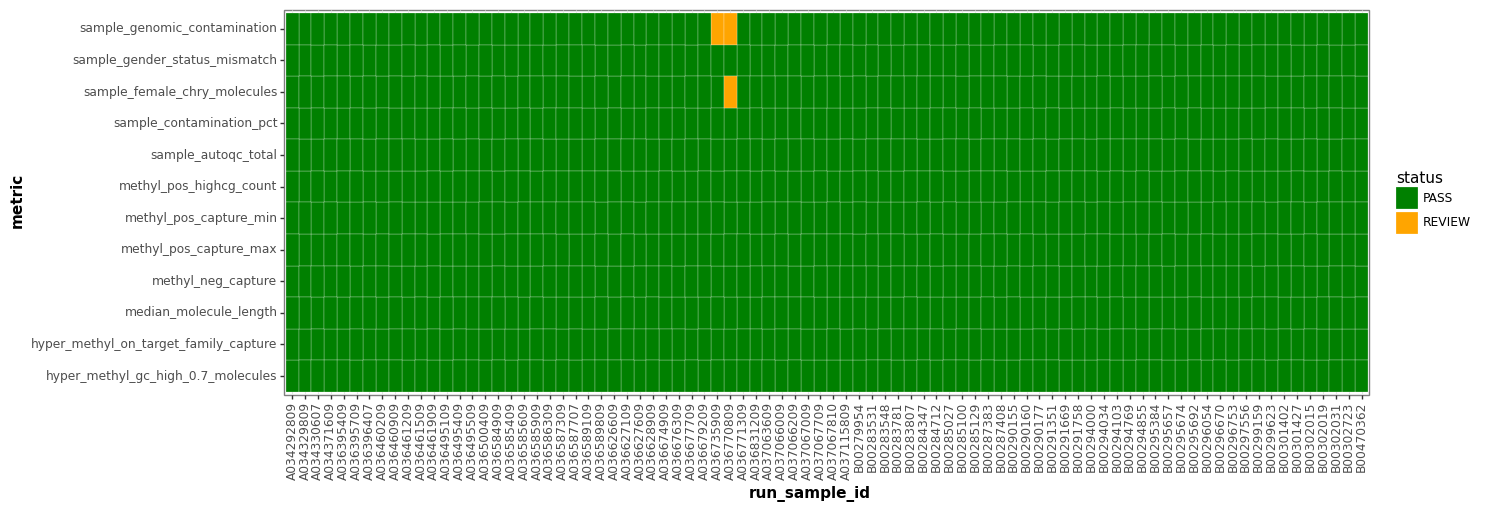

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST03_auto_qc_2024-11-25


In [70]:
plot_qc_heatmap(cos_03_qc_df, out_prefix = "COS_IST03_auto_qc_{}".format(date.today()), width=14, height=5)

In [71]:
12*84

1008

In [126]:
samp_review_lst = cos_03_qc_df.query('status != "PASS"')["run_sample_id"].unique()
cos_03_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
1069,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036735909,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00453,<=,0.5,PASS,5
289,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036735909,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
103,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036735909,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,24.00000,<=,20.0,REVIEW,0
1000,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036770809,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00424,<=,0.5,PASS,5
1071,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036770809,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,76.00000,<=,25.0,REVIEW,0
429,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036770809,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,42.00000,<=,20.0,REVIEW,0


In [127]:
cos_03_df.query('run_sample_id in @samp_review_lst')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
33,34,,A036735909,COS-GC0278,Pre-Surgery,,A0367359,20241120_LH00666_0025_B22V3KWLT3,,,0.001765,PANCANCER,-2.128325,-1.063214,-2.599277,-1.528506,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036735909.oncotrack.pdf
34,35,,A036770809,COS-GC0234,28 Days,,A0367708,20241120_LH00666_0025_B22V3KWLT3,,,0.003098,PANCANCER,-3.245188,-1.010232,-2.007522,-1.499553,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036770809.oncotrack.pdf


In [128]:
cos_03_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
33,A036735909,COS-GC0278,Pre-Surgery,-2.128325,-1.063214,-2.599277,-1.528506
34,A036770809,COS-GC0234,28 Days,-3.245188,-1.010232,-2.007522,-1.499553


In [ ]:
# both methyl negative, so unlikely impacted by contam

### batch 2

In [97]:
cos_03_batch2_df = read_sheet("Copy of COS_IST03_Reveal_02_Run_29058_BART_v0")
cos_03_batch2_df.shape

(84, 22)

In [98]:
cos_03_batch2_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A029517209,COS-GC0001,Pre-Surgery,,A0295172,241120_LH00505_0057_A22V3KJLT3,,,1.443249e-06,PANCANCER,-3.153974,-1.529019,-2.383025,-1.723915,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,A029517209.oncotrack.pdf
1,2,,A029755209,COS-GC0001,14 Days,,A0297552,241120_LH00505_0058_B22V3LJLT3,,,9.382035e-07,PANCANCER,-3.026030,-1.292822,-1.424806,-2.309781,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,A029755209.oncotrack.pdf
2,3,,A029854309,COS-GC0002,Pre-Surgery,,A0298543,241120_LH00505_0058_B22V3LJLT3,,,2.402901e-03,PANCANCER,11.489247,5.271281,11.331605,2.910446,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,A029854309.oncotrack.pdf
3,4,,A030032509,COS-GC0005,Pre-Surgery,,A0300325,241120_LH00505_0058_B22V3LJLT3,,,1.858698e-04,PANCANCER,-2.539931,-0.847299,-1.624798,-0.462486,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,A030032509.oncotrack.pdf
4,5,,A030098013,COS-GC0002,14 Days,,A0300980,241120_LH00505_0058_B22V3LJLT3,,,3.371887e-04,PANCANCER,-2.658938,-0.762989,-2.343423,-0.559740,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,A030098013.oncotrack.pdf


In [103]:
cos_03_batch2_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3',
       '/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3'],
      dtype=object)

In [99]:
cos_03_batch2_qc_df = get_qc(cos_03_batch2_df)

In [100]:
cos_03_batch2_qc_df.shape

(1008, 14)

In [101]:
12*84

1008

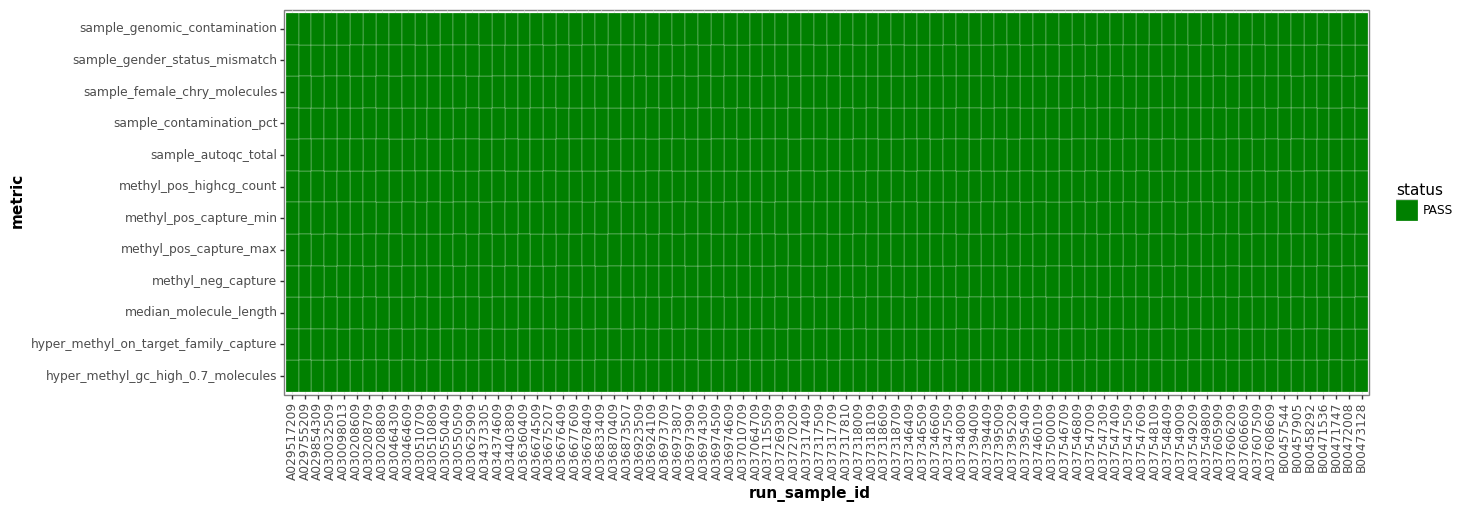

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST03_batch2_auto_qc_2024-11-25


In [102]:
plot_qc_heatmap(cos_03_batch2_qc_df, out_prefix = "COS_IST03_batch2_auto_qc_{}".format(date.today()), width=14, height=5)

### swimmer

In [133]:
cos_03_ruo_report_batch1_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST03_Batch1_84Samples_MonitoringReport.csv",
                              skiprows=1)
cos_03_ruo_report_batch2_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST03_Batch2_84Samples_MonitoringReport.csv",
                              skiprows=1)

cos_03_ruo_report_df = pd.concat([cos_03_ruo_report_batch1_df, cos_03_ruo_report_batch2_df], axis=0)

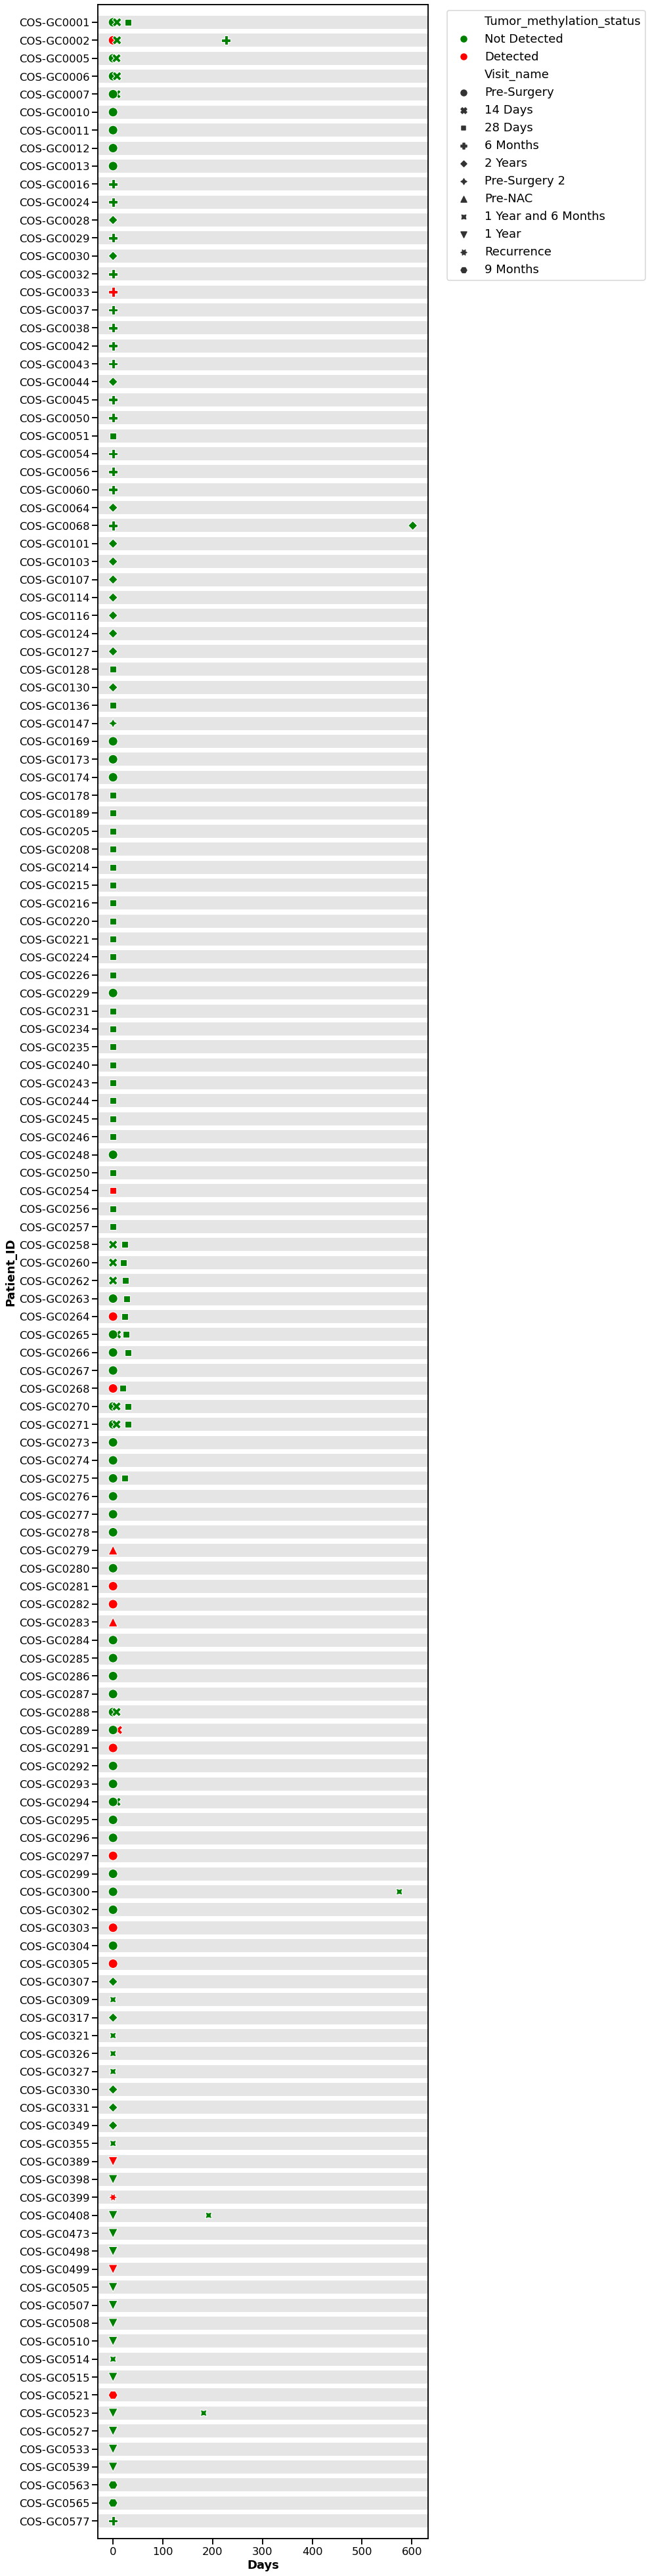

In [136]:
plot_patient_journey(cos_03_ruo_report_df, "COS_IST03")

In [141]:
tot_cnt = cos_03_ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
tot_cnt

,Visit_name,Tumor_methylation_status
0,1 Year,15
1,1 Year and 6 Months,9
2,14 Days,14
3,2 Years,18
4,28 Days,38
5,6 Months,17
6,9 Months,3
7,Pre-NAC,2
8,Pre-Surgery,50
9,Pre-Surgery 2,1


In [142]:
pos_cnt = cos_03_ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_cnt

,Visit_name,Tumor_methylation_status
0,1 Year,2
1,14 Days,1
2,28 Days,1
3,6 Months,1
4,9 Months,1
5,Pre-NAC,2
6,Pre-Surgery,9
7,Recurrence,1


In [158]:
pos_tot_cnt = pos_cnt.merge(tot_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
  "Tumor_methylation_status_x": "Positive",
  "Tumor_methylation_status_y": "Total"
})
# pos_tot_cnt["Positive_percentage"] = (100*pos_tot_cnt["Positive"].div(pos_tot_cnt["Total"])).round(1)

In [159]:
pos_tot_cnt

,Visit_name,Positive,Total
0,1 Year,2.0,15
1,14 Days,1.0,14
2,28 Days,1.0,38
3,6 Months,1.0,17
4,9 Months,1.0,3
5,Pre-NAC,2.0,2
6,Pre-Surgery,9.0,50
7,Recurrence,1.0,1
8,1 Year and 6 Months,0.0,9
9,2 Years,0.0,18


In [165]:
sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
sum_row.loc[0, "Visit_name"] = "Total"
sum_row

,Visit_name,Positive,Total
0,Total,18.0,168


In [167]:
pos_tot_cnt_sum

,Visit_name,Positive,Total
0,1 Year,2.0,15
1,14 Days,1.0,14
2,28 Days,1.0,38
3,6 Months,1.0,17
4,9 Months,1.0,3
5,Pre-NAC,2.0,2
6,Pre-Surgery,9.0,50
7,Recurrence,1.0,1
8,1 Year and 6 Months,0.0,9
9,2 Years,0.0,18


In [171]:
pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)

In [172]:
pos_tot_cnt_sum

,Visit_name,Positive,Total,Positive_percentage
0,1 Year,2.0,15,13.3
1,14 Days,1.0,14,7.1
2,28 Days,1.0,38,2.6
3,6 Months,1.0,17,5.9
4,9 Months,1.0,3,33.3
5,Pre-NAC,2.0,2,100.0
6,Pre-Surgery,9.0,50,18.0
7,Recurrence,1.0,1,100.0
8,1 Year and 6 Months,0.0,9,0.0
9,2 Years,0.0,18,0.0


In [188]:
def calc_pos_rate(ruo_report_df):
  """  """
  tot_cnt = ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
  pos_cnt = ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
  pos_tot_cnt = tot_cnt.merge(pos_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
    "Tumor_methylation_status_x": "Total",
    "Tumor_methylation_status_y": "Positive"
  })

  sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
  sum_row.loc[0, "Visit_name"] = "Total"

  pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
  pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)
  return pos_tot_cnt_sum

In [189]:
calc_pos_rate(cos_03_ruo_report_batch1_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 Year,15,2.0,13.3
1,1 Year and 6 Months,7,0.0,0.0
2,14 Days,5,0.0,0.0
3,2 Years,13,0.0,0.0
4,28 Days,18,0.0,0.0
5,6 Months,5,0.0,0.0
6,9 Months,3,1.0,33.3
7,Pre-NAC,2,2.0,100.0
8,Pre-Surgery,14,3.0,21.4
9,Pre-Surgery 2,1,0.0,0.0


In [190]:
calc_pos_rate(cos_03_ruo_report_batch2_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 Year and 6 Months,2,0.0,0.0
1,14 Days,9,1.0,11.1
2,2 Years,5,0.0,0.0
3,28 Days,20,1.0,5.0
4,6 Months,12,1.0,8.3
5,Pre-Surgery,36,6.0,16.7
0,Total,84,9.0,10.7


## COS_04

### batch 1

In [74]:
cos_04_df = read_sheet("Copy of COS_IST04_Reveal_01_Run_29054_BART_v0")
cos_04_df.shape

(68, 22)

In [75]:
cos_04_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,B00282785,COS-PC0310,6 months,,A0655300,241120_LH00520_0045_B22V37KLT3,,,0.000065,PANCANCER,-3.299652,-1.928511,-2.033063,-1.322745,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00282785.oncotrack.pdf
1,2,,B00282790,COS-PC0182,1 year,,A0655303,241120_LH00520_0045_B22V37KLT3,,,0.000359,PANCANCER,-3.059582,-0.816961,-1.053728,-2.271309,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00282790.oncotrack.pdf
2,3,,B00282799,COS-PC0202,1 year,,A0655309,241120_LH00520_0045_B22V37KLT3,,,0.000204,PANCANCER,-0.683389,-0.457967,-1.021077,-0.604156,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00282799.oncotrack.pdf
3,4,,B00283540,COS-PC0291,9 months,,A0655986,241120_LH00520_0045_B22V37KLT3,,,0.000009,PANCANCER,-2.378667,-0.522121,-1.076978,-0.721514,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00283540.oncotrack.pdf
4,5,,B00283544,COS-PC0439,Pre-Surgery,,A0655989,241120_LH00520_0045_B22V37KLT3,,,0.002024,PANCANCER,3.187179,1.682322,0.491396,4.653348,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00283544.oncotrack.pdf


In [94]:
cos_04_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3',
       '/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3'],
      dtype=object)

In [76]:
cos_04_qc_df = get_qc(cos_04_df)

In [77]:
cos_04_qc_df.shape

(816, 14)

In [78]:
12*68

816

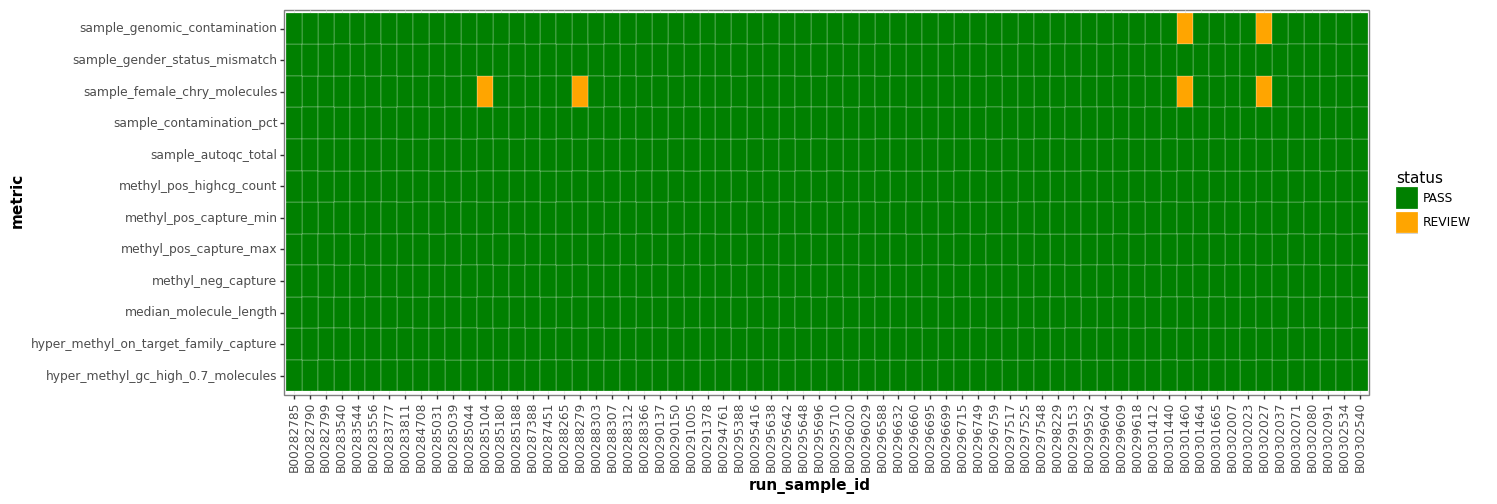

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST04_auto_qc_2024-11-25


In [79]:
plot_qc_heatmap(cos_04_qc_df, out_prefix = "COS_IST04_auto_qc_{}".format(date.today()), width=14, height=5)

In [129]:
samp_review_lst = cos_04_qc_df.query('status != "PASS"')["run_sample_id"].unique()
cos_04_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
27,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00285104,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00879,<=,0.5,PASS,5
239,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00285104,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,55.00000,<=,25.0,REVIEW,0
896,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00285104,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,1.00000,<=,20.0,PASS,0
895,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00288279,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00697,<=,0.5,PASS,5
1112,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00288279,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,70.00000,<=,25.0,REVIEW,0
1055,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00288279,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,4.00000,<=,20.0,PASS,0
214,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00301460,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00508,<=,0.5,PASS,5
527,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00301460,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,141.00000,<=,25.0,REVIEW,0
14,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00301460,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,88.00000,<=,20.0,REVIEW,0
880,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,B00302027,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00429,<=,0.5,PASS,5


In [130]:
cos_04_df.query('run_sample_id in @samp_review_lst')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
12,13,,B00285104,COS-PC0195,1 year,,A0658843,20241120_LH00666_0025_B22V3KWLT3,,,0.000064,PANCANCER,-2.857304,-1.484576,-1.742994,-0.637968,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00285104.oncotrack.pdf
18,19,,B00288279,COS-PC0405,28 days,,A0661668,20241120_LH00666_0025_B22V3KWLT3,,,0.000296,PANCANCER,-2.168721,-1.059530,-0.998527,-0.875096,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00288279.oncotrack.pdf
56,57,,B00301460,COS-PC0199,Recurrence,,A0676845,20241120_LH00666_0025_B22V3KWLT3,,,0.000332,PANCANCER,-2.188507,-1.064471,-1.640094,-0.797704,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00301460.oncotrack.pdf
61,62,,B00302027,COS-PC0419,3 months,,A0677635,20241120_LH00666_0025_B22V3KWLT3,,,0.000055,PANCANCER,-2.652733,-1.804691,-1.395822,-2.297320,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00302027.oncotrack.pdf


In [131]:
cos_04_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
12,B00285104,COS-PC0195,1 year,-2.857304,-1.484576,-1.742994,-0.637968
18,B00288279,COS-PC0405,28 days,-2.168721,-1.059530,-0.998527,-0.875096
56,B00301460,COS-PC0199,Recurrence,-2.188507,-1.064471,-1.640094,-0.797704
61,B00302027,COS-PC0419,3 months,-2.652733,-1.804691,-1.395822,-2.297320


In [ ]:
# both methyl negative, so unlikely impacted by contam

### batch 2

In [104]:
cos_04_batch2_df = read_sheet("Copy of COS_IST04_Reveal_02_Run_29059_BART_v0")
cos_04_batch2_df.shape

(68, 22)

In [105]:
cos_04_batch2_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,B00290635,COS-PC0446,Pre-Surgery,,A0663862,241120_LH00505_0057_A22V3KJLT3,,,0.001096,PANCANCER,8.079734,3.969145,6.188216,3.883152,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00290635.oncotrack.pdf
1,2,,B00291359,COS-PC0290,9 months,,A0664834,241120_LH00505_0057_A22V3KJLT3,,,0.000000,PANCANCER,-3.019632,-1.541139,-1.872833,-1.129681,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00291359.oncotrack.pdf
2,3,,B00291420,COS-PC0388,3 months,,A0664909,241120_LH00505_0057_A22V3KJLT3,,,0.000096,PANCANCER,-2.244715,-0.923651,-1.599757,-2.016145,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00291420.oncotrack.pdf
3,4,,B00291430,COS-PC0381,3 months,,A0664936,241120_LH00505_0057_A22V3KJLT3,,,0.000253,PANCANCER,-2.720205,-1.046224,-1.443934,-1.638494,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00291430.oncotrack.pdf
4,5,,B00291665,COS-PC0468,Enrollment,,A0665609,241120_LH00505_0057_A22V3KJLT3,,,0.000039,PANCANCER,-2.016073,-0.833495,-1.963688,-0.276506,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00291665.oncotrack.pdf


In [106]:
cos_04_batch2_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3',
       '/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3'],
      dtype=object)

In [107]:
cos_04_batch2_qc_df = get_qc(cos_04_batch2_df)

In [108]:
cos_04_batch2_qc_df.shape

(816, 14)

In [109]:
12*68

816

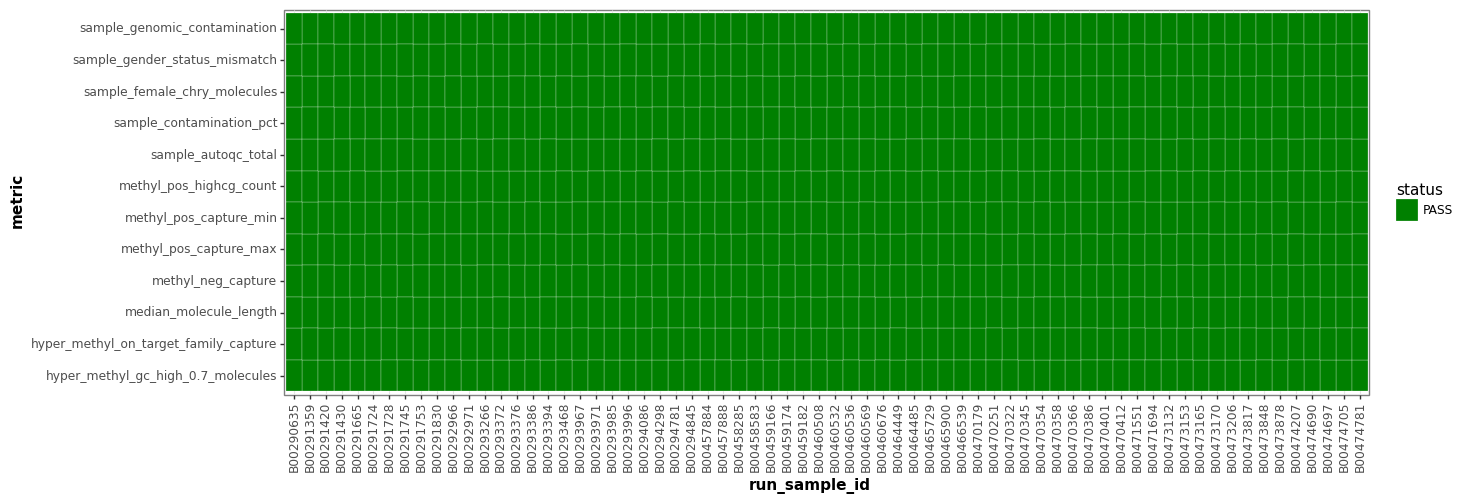

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST04_batch2_auto_qc_2024-11-25


In [110]:
plot_qc_heatmap(cos_04_batch2_qc_df, out_prefix = "COS_IST04_batch2_auto_qc_{}".format(date.today()), width=14, height=5)

### swimmer

In [173]:
cos_04_ruo_report_batch1_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST04_Batch1_68Samples_MonitoringReport.csv",
                              skiprows=1)
cos_04_ruo_report_batch2_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST04_Batch2_68Samples_MonitoringReport.csv",
                              skiprows=1)

cos_04_ruo_report_df = pd.concat([cos_04_ruo_report_batch1_df, cos_04_ruo_report_batch2_df], axis=0)

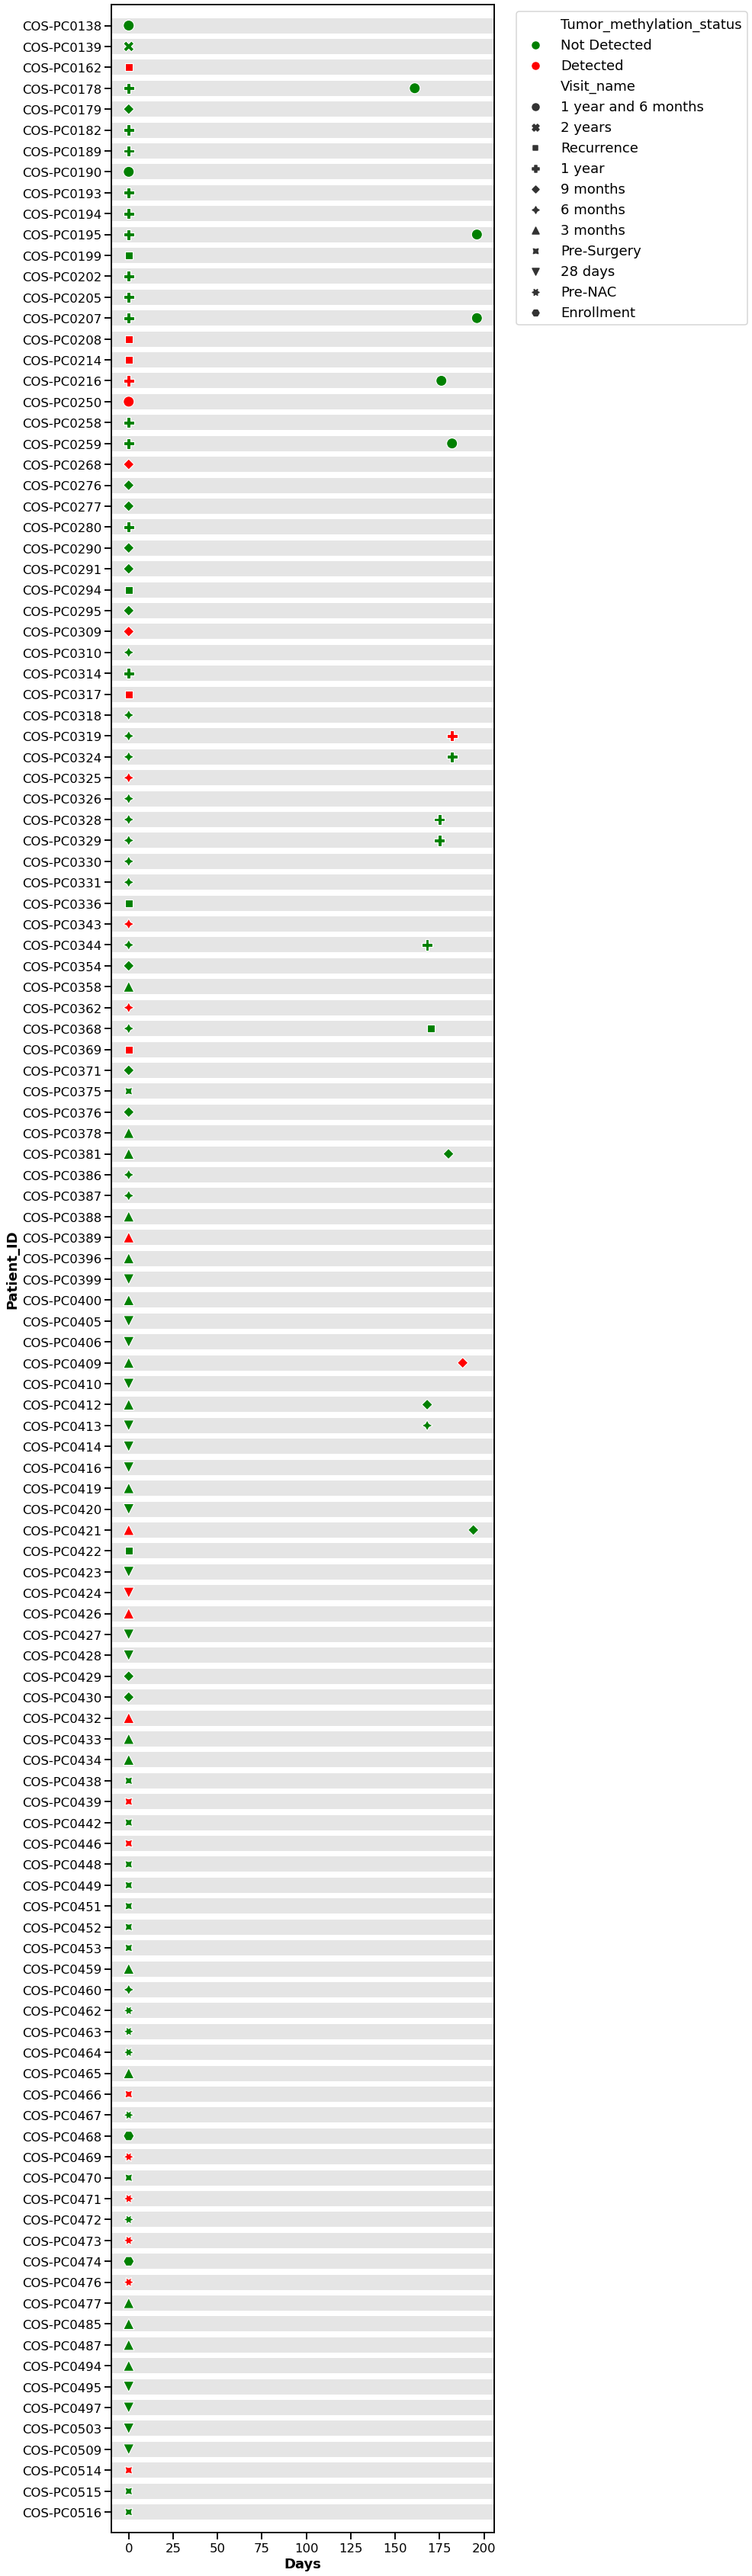

In [174]:
plot_patient_journey(cos_04_ruo_report_df, "COS_IST04")

In [175]:
tot_cnt = cos_04_ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_cnt = cos_04_ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_tot_cnt = pos_cnt.merge(tot_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
  "Tumor_methylation_status_x": "Positive",
  "Tumor_methylation_status_y": "Total"
})

sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
sum_row.loc[0, "Visit_name"] = "Total"

pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)

In [176]:
pos_tot_cnt_sum

,Visit_name,Positive,Total,Positive_percentage
0,1 year,2.0,19,10.5
1,1 year and 6 months,1.0,8,12.5
2,28 days,1.0,16,6.2
3,3 months,4.0,21,19.0
4,6 months,3.0,18,16.7
5,9 months,3.0,17,17.6
6,Pre-NAC,4.0,9,44.4
7,Pre-Surgery,4.0,15,26.7
8,Recurrence,5.0,10,50.0
9,2 years,0.0,1,0.0


In [191]:
calc_pos_rate(cos_04_ruo_report_batch1_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,13,1.0,7.7
1,1 year and 6 months,1,0.0,0.0
2,28 days,7,0.0,0.0
3,3 months,7,2.0,28.6
4,6 months,15,3.0,20.0
5,9 months,5,2.0,40.0
6,Enrollment,1,0.0,0.0
7,Pre-NAC,7,2.0,28.6
8,Pre-Surgery,8,2.0,25.0
9,Recurrence,4,2.0,50.0


In [192]:
calc_pos_rate(cos_04_ruo_report_batch2_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,6,1.0,16.7
1,1 year and 6 months,7,1.0,14.3
2,2 years,1,0.0,0.0
3,28 days,9,1.0,11.1
4,3 months,14,2.0,14.3
5,6 months,3,0.0,0.0
6,9 months,12,1.0,8.3
7,Enrollment,1,0.0,0.0
8,Pre-NAC,2,2.0,100.0
9,Pre-Surgery,7,2.0,28.6


## COS_05

### batch 1

In [82]:
cos_05_df = read_sheet("Copy of COS_IST05_Reveal_01_Run_29056_BART_v0")
cos_05_df.shape

(12, 22)

In [83]:
cos_05_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,B00283790,COS-MEL42,3 months,,A0656280,241120_LH00520_0045_B22V37KLT3,,,0.004476,PANCANCER,-2.961788,-1.022166,-2.667250,0.013683,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00283790.oncotrack.pdf
1,2,,B00285035,COS-MEL34,6 months,,A0658792,241120_LH00520_0045_B22V37KLT3,,,0.000010,PANCANCER,-2.979107,-1.680826,-2.366737,-1.313731,,,,,/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3,B00285035.oncotrack.pdf
2,3,,B00287416,COS-MEL46,3 months,,A0660746,20241120_LH00666_0025_B22V3KWLT3,,,0.000496,PANCANCER,-1.153054,-0.397245,-0.589625,-1.293214,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00287416.oncotrack.pdf
3,4,,B00288335,COS-MEL50,Enrollment,,A0661704,20241120_LH00666_0025_B22V3KWLT3,,,0.000150,PANCANCER,-1.897737,-0.711580,-1.934064,-0.219392,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00288335.oncotrack.pdf
4,5,,B00291741,COS-MEL5,1 year and 6 months,,A0665643,20241120_LH00666_0025_B22V3KWLT3,,,0.000219,PANCANCER,-2.227438,-0.897405,-1.762707,0.025488,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,B00291741.oncotrack.pdf


In [95]:
cos_05_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3',
       '/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3'],
      dtype=object)

In [84]:
cos_05_qc_df = get_qc(cos_05_df)

In [85]:
cos_05_qc_df.shape

(144, 14)

In [86]:
12*12

144

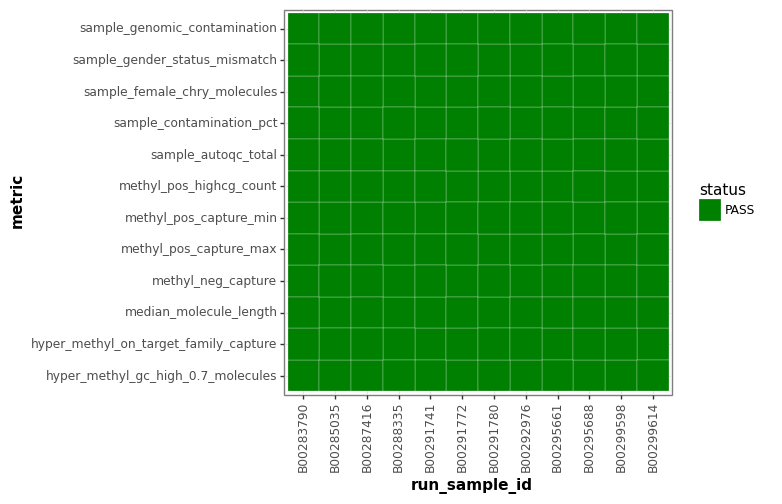

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST05_auto_qc_2024-11-25


In [87]:
plot_qc_heatmap(cos_05_qc_df, out_prefix = "COS_IST05_auto_qc_{}".format(date.today()), width=5, height=5)

### batch 2

In [111]:
cos_05_batch2_df = read_sheet("Copy of COS_IST05_Reveal_02_Run_29060_BART_v0")
cos_05_batch2_df.shape

(12, 22)

In [112]:
cos_05_batch2_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A037347309,COS-MEL1,Enrollment,,A0373473,241120_LH00505_0057_A22V3KJLT3,,,2.242362e-05,PANCANCER,-2.202375,-0.876991,-1.333160,-1.240520,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,A037347309.oncotrack.pdf
1,2,,A037348309,COS-MEL2,Enrollment,,A0373483,241120_LH00505_0057_A22V3KJLT3,,,5.589925e-07,PANCANCER,-4.249663,-1.970211,-2.400784,-1.849979,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,A037348309.oncotrack.pdf
2,3,,B00291736,COS-MEL44,3 months,,A0665638,241120_LH00505_0057_A22V3KJLT3,,,2.798095e-01,PANCANCER,24.255120,22.457870,6.154825,23.947982,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00291736.oncotrack.pdf
3,4,,B00293976,COS-MEL45,3 months,,A0667705,241120_LH00505_0057_A22V3KJLT3,,,4.083666e-05,PANCANCER,-2.724101,-1.376875,-1.448251,-0.536267,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00293976.oncotrack.pdf
4,5,,B00459272,COS-MEL42,9 months,,A0820536,241120_LH00505_0057_A22V3KJLT3,,,2.472117e-05,PANCANCER,-2.856395,-1.421541,-1.617833,-0.464750,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00459272.oncotrack.pdf


In [113]:
cos_05_batch2_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3',
       '/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3'],
      dtype=object)

In [114]:
cos_05_batch2_qc_df = get_qc(cos_05_batch2_df)

In [115]:
cos_05_batch2_qc_df.shape

(144, 14)

In [116]:
12*12

144

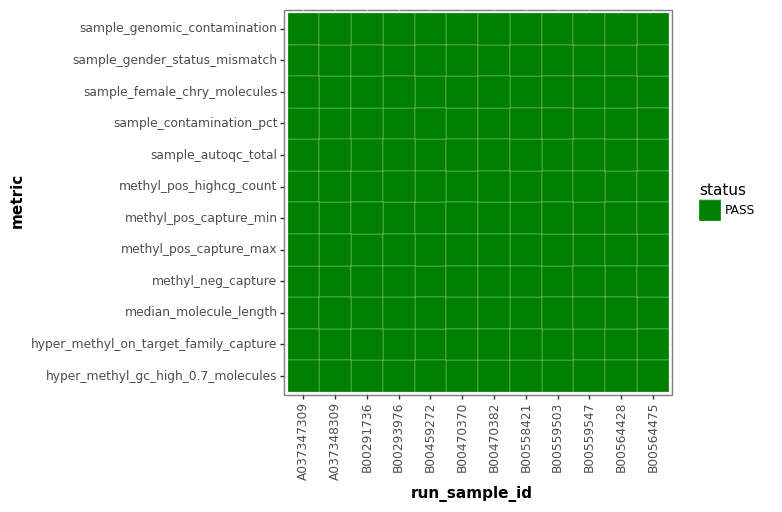

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST05_batch2_auto_qc_2024-11-25


In [117]:
plot_qc_heatmap(cos_05_batch2_qc_df, out_prefix = "COS_IST05_batch2_auto_qc_{}".format(date.today()), width=5, height=5)

### swimmer

In [177]:
cos_05_ruo_report_batch1_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST05_Batch1_12Samples_MonitoringReport.csv",
                              skiprows=1)
cos_05_ruo_report_batch2_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST05_Batch2_12Samples_MonitoringReport.csv",
                              skiprows=1)

cos_05_ruo_report_df = pd.concat([cos_05_ruo_report_batch1_df, cos_05_ruo_report_batch2_df], axis=0)

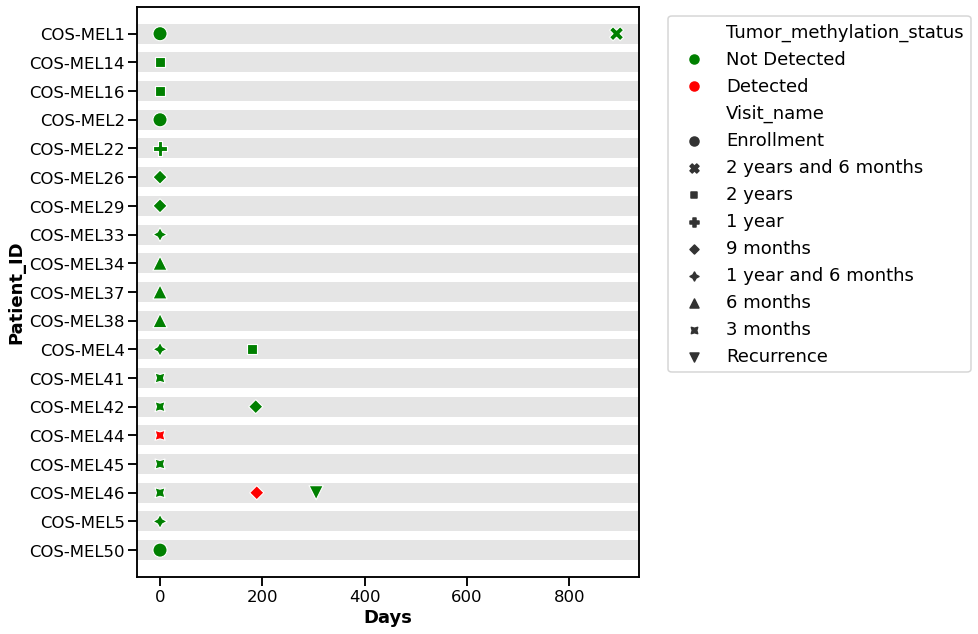

In [178]:
plot_patient_journey(cos_05_ruo_report_df, "COS_IST05")

In [179]:
tot_cnt = cos_05_ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_cnt = cos_05_ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_tot_cnt = pos_cnt.merge(tot_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
  "Tumor_methylation_status_x": "Positive",
  "Tumor_methylation_status_y": "Total"
})

sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
sum_row.loc[0, "Visit_name"] = "Total"

pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)

In [180]:
pos_tot_cnt_sum

,Visit_name,Positive,Total,Positive_percentage
0,3 months,1.0,5,20.0
1,9 months,1.0,4,25.0
2,1 year,0.0,1,0.0
3,1 year and 6 months,0.0,3,0.0
4,2 years,0.0,3,0.0
5,2 years and 6 months,0.0,1,0.0
6,6 months,0.0,3,0.0
7,Enrollment,0.0,3,0.0
8,Recurrence,0.0,1,0.0
0,Total,2.0,24,8.3


In [193]:
calc_pos_rate(cos_05_ruo_report_batch1_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,1,0.0,0.0
1,1 year and 6 months,2,0.0,0.0
2,3 months,3,0.0,0.0
3,6 months,3,0.0,0.0
4,9 months,2,0.0,0.0
5,Enrollment,1,0.0,0.0
0,Total,12,0.0,0.0


In [194]:
calc_pos_rate(cos_05_ruo_report_batch2_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year and 6 months,1,0.0,0.0
1,2 years,3,0.0,0.0
2,2 years and 6 months,1,0.0,0.0
3,3 months,2,1.0,50.0
4,9 months,2,1.0,50.0
5,Enrollment,2,0.0,0.0
6,Recurrence,1,0.0,0.0
0,Total,12,2.0,16.7


## COS_06

### batch 1

In [88]:
cos_06_df = read_sheet("Copy of COS_IST06_Reveal_01_Run_29057_BART_v0")
cos_06_df.shape

(24, 22)

In [89]:
cos_06_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A036395109,COS-HCC0002,3 months,,A0363951,20241120_LH00666_0025_B22V3KWLT3,,,0.000052,PANCANCER,-2.857636,-1.263730,-1.257645,-1.932037,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036395109.oncotrack.pdf
1,2,,A036395909,COS-HCC0006,Enrollment,,A0363959,20241120_LH00666_0025_B22V3KWLT3,,,0.002520,PANCANCER,8.433292,4.665525,3.834031,3.848137,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036395909.oncotrack.pdf
2,3,,A036590009,COS-HCC0007,Enrollment,,A0365900,20241120_LH00666_0025_B22V3KWLT3,,,0.001118,PANCANCER,2.150460,1.612692,0.169564,1.172142,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036590009.oncotrack.pdf
3,4,,A036590609,COS-HCC0001,3 months,,A0365906,20241120_LH00666_0025_B22V3KWLT3,,,0.001767,PANCANCER,3.247845,0.780042,0.678498,-0.348428,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036590609.oncotrack.pdf
4,5,,A036674009,COS-HCC0008,Enrollment,,A0366740,20241120_LH00666_0025_B22V3KWLT3,,,0.103521,PANCANCER,17.641993,11.557865,8.314058,10.145093,,,,,/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3,A036674009.oncotrack.pdf


In [96]:
cos_06_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3',
       '/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3'],
      dtype=object)

In [90]:
cos_06_qc_df = get_qc(cos_06_df)

In [91]:
cos_06_qc_df.shape

(288, 14)

In [92]:
12*24

288

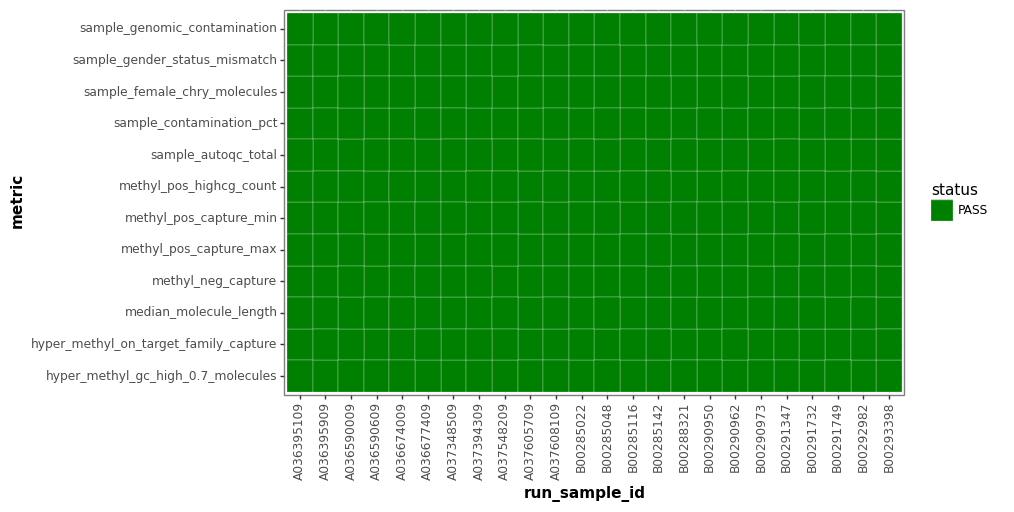

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST06_auto_qc_2024-11-25


In [93]:
plot_qc_heatmap(cos_06_qc_df, out_prefix = "COS_IST06_auto_qc_{}".format(date.today()), width=8, height=5)

### batch 2

In [118]:
cos_06_batch2_df = read_sheet("Copy of COS_IST06_Reveal_02_Run_29061_BART_v0")
cos_06_batch2_df.shape

(24, 22)

In [119]:
cos_06_batch2_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A037550709,COS-HCC0010,Enrollment,,A0375507,241120_LH00505_0057_A22V3KJLT3,,,0.000315,PANCANCER,-2.947309,-0.993152,-1.971682,-1.554334,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,A037550709.oncotrack.pdf
1,2,,B00277313,COS-HCC0063,1 year,,A0646944,241120_LH00505_0058_B22V3LJLT3,,,0.000245,PANCANCER,-2.098285,-1.051066,-1.975186,-1.043182,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,B00277313.oncotrack.pdf
2,3,,B00277357,COS-HCC0010,1 year and 6 months,,A0647038,241120_LH00505_0058_B22V3LJLT3,,,0.000104,PANCANCER,-3.288078,-1.579787,-1.656258,-1.934330,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,B00277357.oncotrack.pdf
3,4,,B00278869,COS-HCC0084,9 months,,A0649085,241120_LH00505_0058_B22V3LJLT3,,,0.000435,PANCANCER,-1.555261,-0.968604,-2.160457,-1.247020,,,,,/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3,B00278869.oncotrack.pdf
4,5,,B00278891,COS-HCC0090,9 months,,A0649089,241120_LH00505_0057_A22V3KJLT3,,,0.000223,PANCANCER,-2.125281,-1.188111,-1.643190,-0.590013,,,,,/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3,B00278891.oncotrack.pdf


In [120]:
cos_06_batch2_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3',
       '/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3'],
      dtype=object)

In [121]:
cos_06_batch2_qc_df = get_qc(cos_06_batch2_df)

In [122]:
cos_06_batch2_qc_df.shape

(288, 14)

In [123]:
12*24

288

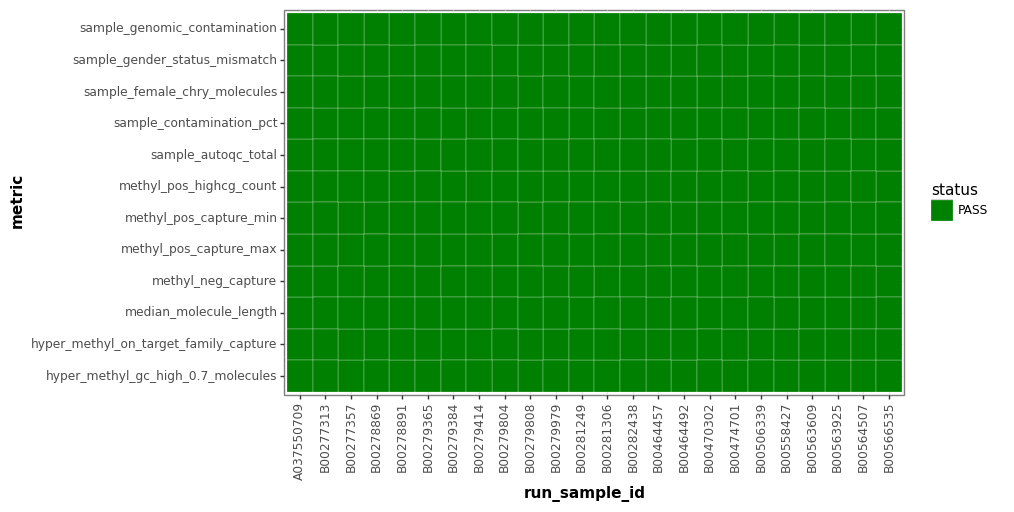

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: COS_IST06_batch2_auto_qc_2024-11-25


In [124]:
plot_qc_heatmap(cos_06_batch2_qc_df, out_prefix = "COS_IST06_batch2_auto_qc_{}".format(date.today()), width=8, height=5)

### swimmer

In [181]:
cos_06_ruo_report_batch1_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST06_Batch1_24Samples_MonitoringReport.csv",
                              skiprows=1)
cos_06_ruo_report_batch2_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST06_Batch2_24Samples_MonitoringReport.csv",
                              skiprows=1)

cos_06_ruo_report_df = pd.concat([cos_06_ruo_report_batch1_df, cos_06_ruo_report_batch2_df], axis=0)

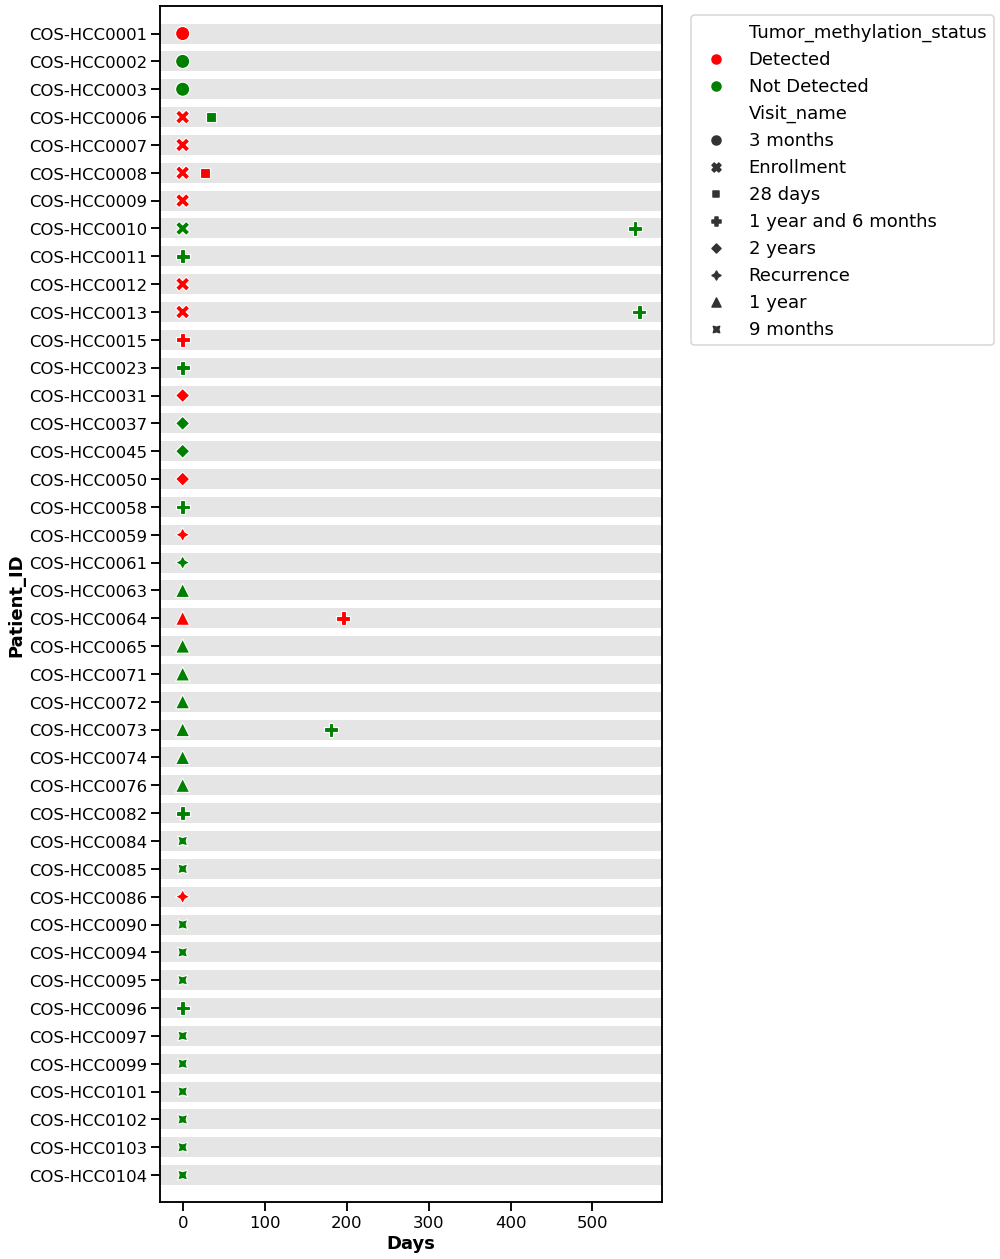

In [182]:
plot_patient_journey(cos_06_ruo_report_df, "COS_IST06")

In [183]:
tot_cnt = cos_06_ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_cnt = cos_06_ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
pos_tot_cnt = pos_cnt.merge(tot_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
  "Tumor_methylation_status_x": "Positive",
  "Tumor_methylation_status_y": "Total"
})

sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
sum_row.loc[0, "Visit_name"] = "Total"

pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)

In [184]:
pos_tot_cnt_sum

,Visit_name,Positive,Total,Positive_percentage
0,1 year,1.0,8,12.5
1,1 year and 6 months,2.0,10,20.0
2,2 years,2.0,4,50.0
3,28 days,1.0,2,50.0
4,3 months,1.0,3,33.3
5,Enrollment,6.0,7,85.7
6,Recurrence,2.0,3,66.7
7,9 months,0.0,11,0.0
0,Total,15.0,48,31.2


In [195]:
calc_pos_rate(cos_06_ruo_report_batch1_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,6,0.0,0.0
1,1 year and 6 months,2,1.0,50.0
2,28 days,2,1.0,50.0
3,3 months,3,1.0,33.3
4,9 months,5,0.0,0.0
5,Enrollment,6,6.0,100.0
0,Total,24,9.0,37.5


In [196]:
calc_pos_rate(cos_06_ruo_report_batch2_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,2,1.0,50.0
1,1 year and 6 months,8,1.0,12.5
2,2 years,4,2.0,50.0
3,9 months,6,0.0,0.0
4,Enrollment,1,0.0,0.0
5,Recurrence,3,2.0,66.7
0,Total,24,6.0,25.0


In [198]:
cos_03_qc_df.to_csv("COS_IST03_batch1_qc.csv", index=False)
cos_03_batch2_qc_df.to_csv("COS_IST03_batch2_qc.csv", index=False)

cos_04_qc_df.to_csv("COS_IST04_batch1_qc.csv", index=False)
cos_04_batch2_qc_df.to_csv("COS_IST04_batch2_qc.csv", index=False)

cos_05_qc_df.to_csv("COS_IST05_batch1_qc.csv", index=False)
cos_05_batch2_qc_df.to_csv("COS_IST05_batch2_qc.csv", index=False)

cos_06_qc_df.to_csv("COS_IST06_batch1_qc.csv", index=False)
cos_06_batch2_qc_df.to_csv("COS_IST06_batch2_qc.csv", index=False)

In [199]:
cos_06_qc_df.shape

(288, 14)

In [200]:
cos_06_batch2_qc_df.shape

(288, 14)

In [201]:
cos_06_batch2_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
26,241120_LH00505_0057_A22V3KJLT3,NRE20241001R0023,B00563609,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.44231,>=,1.10,PASS,5
27,241120_LH00505_0057_A22V3KJLT3,NRE20241001R0023,B00563609,sample,EpiReveal-1.0.0-RLS,DNA,sample_gender_status_mismatch,Gender Status Mismatch,code,0.00000,==,0.00,PASS,0
39,241120_LH00505_0057_A22V3KJLT3,NRE20241001R0023,B00558427,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.43645,<=,2.00,PASS,5
42,241120_LH00505_0057_A22V3KJLT3,NRE20241001R0023,B00563925,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_gc_high_0.7_molecules,High GC molecules 0.7 (Hyper-partition:methyl-subpanel),fraction of molecules,0.24759,>=,0.01,PASS,5
45,241120_LH00505_0057_A22V3KJLT3,NRE20241001R0023,A037550709,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,170.00000,<=,218.00,PASS,0


In [202]:
cos_06_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
2,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A037605709,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,7.99000,>=,2.80,PASS,3
7,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A036677409,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.51892,<=,2.00,PASS,5
10,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A037394309,sample,EpiReveal-1.0.0-RLS,DNA,sample_gender_status_mismatch,Gender Status Mismatch,code,0.00000,==,0.00,PASS,0
24,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A037548209,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_gc_high_0.7_molecules,High GC molecules 0.7 (Hyper-partition:methyl-subpanel),fraction of molecules,0.22363,>=,0.01,PASS,5
31,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,A037605709,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.49519,<=,2.00,PASS,5


In [203]:
os.getcwd()

'/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval'

## Dec 5, update plasma volume

In [291]:
sample_data_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/pdw/batch_sample_data.csv", low_memory=False)
sample_data_df.head()

,projectid,u_plasmabatchid,accn_id,sampleid,runid,plasma_volume,total_yield,plasma_volume_observed,plasma_volume_remaining,samplegenepanelversion,u_addicancelcomment,cancelledreason,sample_failedreason,reportstatus,requeststatus,recordstatus,samplestatus,gh_requesttype,sampletype,project_id,early_stage
0,SLLIP_01,dblazczak03192018_1,A0101251,A010125101,180322_NB501059_0378_AHYLY2BGX3,NaN,NaN,NaN,NaN,2.10.1,NaN,NaN,NaN,FINAL,Released,Activating,Analytics in progress,Pharma,Blood,NaN,NaN
1,GHI_02,NaN,A01149,A0114902_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Research,DNA,NaN,NaN
2,MED_19,MED_MYSTIC_252samples_20180828,A0121263,A012126302,NaN,0.75,NaN,NaN,NaN,1.0,Failed Enrichment,Other,NaN,NaN,Released,NaN,Ready for DNA Extraction,Research,Blood,NaN,NaN
3,VIS_01,cliu10272018_11,A0129355,A012935503,NaN,NaN,NaN,NaN,NaN,2.10,NaN,NaN,NaN,NaN,Released,NaN,Dispositioned,Pharma,Blood,VIS_01,False
4,PFZ_08,Pfizer_SOW8_20180925_1331tubes,A0134656,A013465603,NaN,0.0,NaN,NaN,NaN,2.10.1,NaN,NaN,NaN,NaN,Released,NaN,Depleted,Research,Blood,PFZ_08,False


In [221]:
def line_prepender(filename, line):
  """ prepend a line to the beginning of a file """
  with open(filename, 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    f.write(line.rstrip('\r\n') + '\n' + content)

### COS_03

#### batch 1

In [243]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST03_Batch1_84Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241205_NationalCancerCenterEast_IST03_Batch1_84Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv,
                              skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()

In [244]:
first_line

'Number of samples: 84; bip_version:EpiReveal-1.0.0-RLS; report_modules: ; panel:. \n'

In [245]:
ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,NaN,NaN,A0342928,A034292809,COS-GC0136,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,03/31/2021,03/29/2021,11/25/2024
1,NaN,NaN,A0343298,A034329809,COS-GC0051,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/01/2021,03/30/2021,11/25/2024
2,NaN,NaN,A0343306,A034330607,COS-GC0147,NaN,NaN,Pre-Surgery 2,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/01/2021,03/30/2021,11/25/2024
3,NaN,NaN,A0343716,A034371609,COS-GC0128,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/02/2021,03/31/2021,11/25/2024
4,NaN,NaN,A0363954,A036395409,COS-GC0268,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.00213,NaN,NaN,NaN,06/09/2021,06/08/2021,11/25/2024


In [246]:
ruo_report_cols_lst = ruo_report_df.columns

In [247]:
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged.shape

(84, 40)

In [248]:
ruo_report_df_merged.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,projectid,u_plasmabatchid,accn_id,sampleid,runid,plasma_volume,total_yield,plasma_volume_observed,plasma_volume_remaining,samplegenepanelversion,u_addicancelcomment,cancelledreason,sample_failedreason,reportstatus,requeststatus,recordstatus,samplestatus,gh_requesttype,sampletype,project_id,early_stage
0,NaN,NaN,A0342928,A034292809,COS-GC0136,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,03/31/2021,03/29/2021,11/25/2024,COS_03,COS_IST03_Reveal_01,A0342928,A034292809,NaN,4.5,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False
1,NaN,NaN,A0343298,A034329809,COS-GC0051,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/01/2021,03/30/2021,11/25/2024,COS_03,COS_IST03_Reveal_01,A0343298,A034329809,NaN,4.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False
2,NaN,NaN,A0343306,A034330607,COS-GC0147,NaN,NaN,Pre-Surgery 2,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/01/2021,03/30/2021,11/25/2024,COS_03,COS_IST03_Reveal_01,A0343306,A034330607,NaN,4.5,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False
3,NaN,NaN,A0343716,A034371609,COS-GC0128,NaN,NaN,28 Days,SUCCESS,NaN,Not Detected,Not Detected,0.00000,NaN,NaN,NaN,04/02/2021,03/31/2021,11/25/2024,COS_03,COS_IST03_Reveal_01,A0343716,A034371609,NaN,3.5,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False
4,NaN,NaN,A0363954,A036395409,COS-GC0268,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.00213,NaN,NaN,NaN,06/09/2021,06/08/2021,11/25/2024,COS_03,COS_IST03_Reveal_01,A0363954,A036395409,NaN,4.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False


In [249]:
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

In [250]:
new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0    28
4.5    27
3.5    17
3.0     6
2.5     3
2.0     2
NaN     1
Name: Plasma_ml_input, dtype: int64

In [251]:
sample_data_df.query('accn_id == "A0670246"')

,projectid,u_plasmabatchid,accn_id,sampleid,runid,plasma_volume,total_yield,plasma_volume_observed,plasma_volume_remaining,samplegenepanelversion,u_addicancelcomment,cancelledreason,sample_failedreason,reportstatus,requeststatus,recordstatus,samplestatus,gh_requesttype,sampletype,project_id,early_stage
72162,COS_03,anglee02202023_2,A0670246,B00295660,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Ready for DNA Extraction,Research,Plasma,COS_03,False
89732,COS_03,anglee02202023_2,A0670246,B00295659,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Ready for DNA Extraction,Research,Plasma,COS_03,False
232986,COS_03,anglee02202023_2,A0670246,B00295658,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Ready for DNA Extraction,Research,Plasma,COS_03,False
237377,COS_03,COS_IST03_Reveal_01,A0670246,B00295657,NaN,NaN,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,Ready For Variant Upload,NaN,Analytics in progress,Research,Plasma,COS_03,False


In [252]:
new_ruo_report_df.query('Plasma_ml_input != Plasma_ml_input')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
68,COSMOS-GC-01,NaN,A0670246,B00295657,COS-GC0507,NaN,NaN,1 Year,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,NaN,0,02/20/2023,02/17/2023,11/25/2024


In [257]:
## manually update it for B00295657
new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"]=="B00295657", "Plasma_ml_input"] = "3.5"
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

In [258]:
new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0    28
4.5    27
3.5    18
3.0     6
2.5     3
2.0     2
Name: Plasma_ml_input, dtype: int64

In [259]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [260]:
new_ruo_report_df["GHSampleID"].nunique()

84

In [261]:
new_ruo_report_df["Patient_ID"].nunique()

80

#### batch 2

In [229]:
os.getcwd()

'/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval'

In [292]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST03_Batch2_84Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241209_NationalCancerCenterEast_IST03_Batch2_84Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0    51
4.5    19
3.5    10
3.0     2
2.0     1
2.5     1
Name: Plasma_ml_input, dtype: int64

In [293]:
new_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,NaN,NaN,A0295172,A029517209,COS-GC0001,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.5,0,10/15/2020,10/14/2020,11/25/2024
1,NaN,NaN,A0297552,A029755209,COS-GC0001,NaN,NaN,14 Days,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,3.5,0,10/23/2020,10/22/2020,11/25/2024
2,NaN,NaN,A0298543,A029854309,COS-GC0002,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.002403,NaN,3.5,0,10/28/2020,10/27/2020,11/25/2024
3,NaN,NaN,A0300325,A030032509,COS-GC0005,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,3.5,0,11/03/2020,11/02/2020,11/25/2024
4,NaN,NaN,A0300980,A030098013,COS-GC0002,NaN,NaN,14 Days,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,3.5,0,11/05/2020,11/04/2020,11/25/2024


In [294]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [295]:
new_ruo_report_df["GHSampleID"].nunique()

84

In [296]:
new_ruo_report_df["Patient_ID"].nunique()

74

### COS_04

#### batch 1

In [262]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST04_Batch1_68Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241205_NationalCancerCenterEast_IST04_Batch1_68Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0     23
3.5     14
4.5     11
3.0     10
2.5      5
2.0      2
1.5      2
15.0     1
Name: Plasma_ml_input, dtype: int64

In [265]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [263]:
new_ruo_report_df["GHSampleID"].nunique()

68

In [264]:
new_ruo_report_df["Patient_ID"].nunique()

68

#### batch 2

In [301]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST04_Batch2_68Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241209_NationalCancerCenterEast_IST04_Batch2_68Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0    21
3.0    14
3.5    12
4.5     8
2.5     7
2.0     4
1.0     1
1.5     1
Name: Plasma_ml_input, dtype: int64

In [302]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [303]:
new_ruo_report_df["GHSampleID"].nunique()

68

In [304]:
new_ruo_report_df["Patient_ID"].nunique()

66

### COS_05

#### batch 1

In [275]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST05_Batch1_12Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241205_NationalCancerCenterEast_IST05_Batch1_12Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

3.5    4
3.0    3
2.5    3
4.0    2
Name: Plasma_ml_input, dtype: int64

In [276]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [277]:
new_ruo_report_df["GHSampleID"].nunique()

12

In [278]:
new_ruo_report_df["Patient_ID"].nunique()

12

#### batch 2

In [305]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST05_Batch2_12Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241209_NationalCancerCenterEast_IST05_Batch2_12Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

2.5    4
4.5    2
3.5    2
3.0    2
4.0    2
Name: Plasma_ml_input, dtype: int64

In [306]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [307]:
new_ruo_report_df["GHSampleID"].nunique()

12

In [308]:
new_ruo_report_df["Patient_ID"].nunique()

10

### COS_06

#### batch 1

In [283]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST06_Batch1_24Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241205_NationalCancerCenterEast_IST06_Batch1_24Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

4.0    8
3.0    5
2.5    4
4.5    3
3.5    3
2.0    1
Name: Plasma_ml_input, dtype: int64

In [284]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [285]:
new_ruo_report_df["GHSampleID"].nunique()

24

In [286]:
new_ruo_report_df["Patient_ID"].nunique()

22

#### batch 2

In [309]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20241125_NationalCancerCenterEast_IST06_Batch2_24Samples_MonitoringReport.csv"
new_ruo_report_csv = "20241209_NationalCancerCenterEast_IST06_Batch2_24Samples_MonitoringReport.csv"

ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()
    
ruo_report_cols_lst = ruo_report_df.columns
ruo_report_df_merged = ruo_report_df.merge(sample_data_df, left_on=["GHSampleID"], right_on=["sampleid"], how="left")
ruo_report_df_merged["Plasma_ml_input"] = ruo_report_df_merged["plasma_volume"]
ruo_report_df_merged["Plasma_ml_remaining"] = 0

new_ruo_report_df = ruo_report_df_merged[ruo_report_cols_lst].copy()
new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

new_ruo_report_df["Plasma_ml_input"].value_counts(dropna=False)

3.0    8
2.5    7
4.0    4
3.5    3
4.5    2
Name: Plasma_ml_input, dtype: int64

In [310]:
ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]).equals(new_ruo_report_df.drop(columns=["Plasma_ml_input", "Plasma_ml_remaining"]))

True

In [311]:
new_ruo_report_df["GHSampleID"].nunique()

24

In [312]:
new_ruo_report_df["Patient_ID"].nunique()

22

In [313]:
os.getcwd()

'/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval'

In [316]:
set(cos_03_df["data_dir"].unique()) | \
  set(cos_03_batch2_df["data_dir"].unique()) | \
  set(cos_04_df["data_dir"].unique()) | \
  set(cos_04_batch2_df["data_dir"].unique()) | \
  set(cos_05_df["data_dir"].unique()) | \
  set(cos_05_batch2_df["data_dir"].unique()) | \
  set(cos_06_df["data_dir"].unique()) | \
  set(cos_06_batch2_df["data_dir"].unique())

{'/ghds/ivd/flowcentral/20241120_LH00666_0025_B22V3KWLT3',
 '/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3',
 '/ghds/ivd/flowcentral/241120_LH00505_0058_B22V3LJLT3',
 '/ghds/ivd/flowcentral/241120_LH00520_0045_B22V37KLT3'}

In [319]:
all_quto_qc_df_all_lst = []

for bip_dir in set(cos_03_df["data_dir"].unique()) | \
  set(cos_03_batch2_df["data_dir"].unique()) | \
  set(cos_04_df["data_dir"].unique()) | \
  set(cos_04_batch2_df["data_dir"].unique()) | \
  set(cos_05_df["data_dir"].unique()) | \
  set(cos_05_batch2_df["data_dir"].unique()) | \
  set(cos_06_df["data_dir"].unique()) | \
  set(cos_06_batch2_df["data_dir"].unique()):
  
  print(fc_dir)
  
  auto_qc_tsv = f"{bip_dir}/autoqc_sample_qc.hdr.tsv"
  quto_qc_df = pd.read_csv(auto_qc_tsv, sep="\t")
  all_quto_qc_df_all_lst.append(quto_qc_df)

  all_quto_qc_df_all = pd.concat(all_quto_qc_df_all_lst, axis=0)

/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3
/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3
/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3
/ghds/ivd/flowcentral/241120_LH00505_0057_A22V3KJLT3


In [324]:
all_quto_qc_df_all.query('run_sample_id==run_sample_id & run_sample_id.str.startswith("EPC")', engine = "python").to_csv("EPC_QC.csv", index=False)

In [325]:
all_quto_qc_df_all.query('run_sample_id==run_sample_id & run_sample_id.str.startswith("EPC")', engine = "python").head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
132,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,EPC1458000010232,control,EpiReveal-1.0.0-RLS,DNA,tumor_fraction_high_lower_bound,Tumor Fraction High Peak Lower,tumor fraction,0.131012,>=,0.03720,PASS,6
241,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,EPC1458000010232,control,EpiReveal-1.0.0-RLS,DNA,tumor_fraction_low_upper_bound,Tumor Fraction Low Peak Upper,tumor fraction,0.018926,<=,0.03566,PASS,6
246,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,EPC1458000010232,control,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.490300,>=,1.10000,PASS,5
392,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,EPC1458000010232,control,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_gc_high_0.7_molecules,High GC molecules 0.7 (Hyper-partition:methyl-subpanel),fraction of molecules,0.233530,>=,0.01000,PASS,5
531,20241120_LH00666_0025_B22V3KWLT3,NRE20241001R0020,EPC1458000010232,control,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,77512.000000,>=,13500.00000,PASS,0


In [326]:
all_quto_qc_df_all.query('run_sample_id==run_sample_id & run_sample_id.str.startswith("EPC")', engine = "python")["runid"].unique()

array(['20241120_LH00666_0025_B22V3KWLT3',
       '241120_LH00520_0045_B22V37KLT3', '241120_LH00505_0058_B22V3LJLT3',
       '241120_LH00505_0057_A22V3KJLT3'], dtype=object)

In [327]:
os.getcwd()

'/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval'